# Differential Loops and TADs

In [1]:
import os
import importlib
import warnings
from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/050225"
dtree = DataTree("../data")

In [4]:
reps = ["rep1", "rep2", "rep3"]
loader = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "25Kb", c] for c in reps
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250}, obs_cols_add=["Cell_ID"])
celldfs = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "cell_type", c] for c in reps
}).read_data()

## Differential TAD demo

In [5]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)
sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:19: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]
/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:19: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


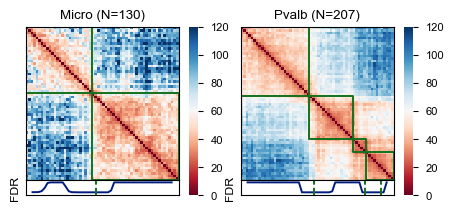

In [14]:
adata1 = adata[adata.obs["cell_type"] == "Micro"]
adata2 = adata[adata.obs["cell_type"] == "Pvalb"]
caller = sf.tl.TADCaller(tree=False, window=4e5)
fig, axes = plt.subplots(1, 2, figsize=(4.3, 2))
sf.pl.domain_boundary(adata1, caller, ax=axes[0], vmax=120, 
                      title=f"Micro (N={adata1.shape[0]})")
sf.pl.domain_boundary(adata2, caller, ax=axes[1], vmax=120, 
                      title=f"Pvalb (N={adata2.shape[0]})")
fig.savefig(os.path.join(out_dire, "Micro_Pvalb_TADs.pdf"), bbox_inches="tight")

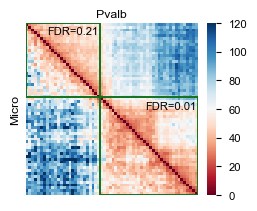

In [15]:
caller = sf.tl.TADCaller(tree=False, window=4e5)
res = caller.to_bedpe(caller.call_tads(adata1))
diff = sf.tl.DiffRegion(adata1, adata2)
res_diff = diff.diff_region(res)

fig, ax = plt.subplots(figsize=(2.5, 2))
sf.pl.pairwise_heatmap(
    X2=sf.pp.median_pdist(adata1, inplace=False),
    X1=sf.pp.median_pdist(adata2, inplace=False),
    y="Micro", x="Pvalb", ax=ax, vmax=120
)
sf.pl.add_domain_fdr(ax, res_diff)
fig.savefig(os.path.join(out_dire, "Micro_Pvalb_dTAD.pdf"), bbox_inches="tight")

In [16]:
res_diff

,c1,s1,e1,c2,s2,e2,stat1,stat2,level,idx1,idx2,stat,pval,fdr,log_fdr
0,chr3,7675000,7700000,chr3,8525000,8550000,NaN,1.633124e+16,0,0,28,4.183317,0.074689,0.074689,-2.594426
1,chr3,8525000,8550000,chr3,9300000,9325000,1.633124e+16,NaN,0,28,59,16.300974,0.019503,0.039005,-3.244060


/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:22: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:22: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


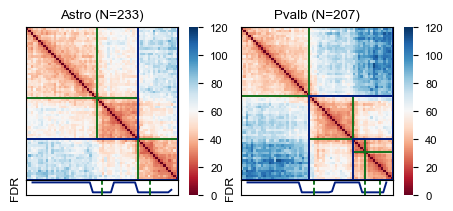

In [8]:
adata1 = adata[adata.obs["cell_type"] == "Astro"]
adata2 = adata[adata.obs["cell_type"] == "Pvalb"]
caller = sf.tl.TADCaller(tree=True, window=4e5)
fig, axes = plt.subplots(1, 2, figsize=(4.3, 2))
sf.pl.domain_boundary(adata1, caller, ax=axes[0], vmax=120, 
                      title=f"Astro (N={adata1.shape[0]})")
sf.pl.domain_boundary(adata2, caller, ax=axes[1], vmax=120, 
                      title=f"Pvalb (N={adata2.shape[0]})")
fig.savefig(os.path.join(out_dire, "Astro_Pvalb_TADs.pdf"), bbox_inches="tight")

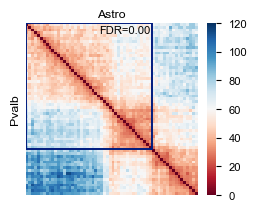

In [9]:
caller = sf.tl.TADCaller(tree=True, window=4e5)
res = caller.to_bedpe(caller.call_tads(adata1))
diff = sf.tl.DiffRegion(adata1, adata2)
res_diff = diff.diff_region(res[res["level"]==1])

fig, ax = plt.subplots(figsize=(2.5, 2))
sf.pl.pairwise_heatmap(
    X1=sf.pp.median_pdist(adata1, inplace=False),
    X2=sf.pp.median_pdist(adata2, inplace=False),
    x="Astro", y="Pvalb", ax=ax, vmax=120
)
sf.pl.add_domain_fdr(ax, res_diff)
fig.savefig(os.path.join(out_dire, "Astro_Pvalb_dTAD.pdf"), bbox_inches="tight")

## Control type I error rate

In [14]:
loaders = {
    c: sf.pp.FOF_CT_Loader(dtree["takei_science_2021", "25Kb", c], 
                           voxel_ratio={"X": 103, "Y": 103, "Z": 250}, 
                           obs_cols_add=["Cell_ID"])
    for c in ["rep1", "rep2", "rep3"]
}
for k, v in loaders.items():
    adata = v.create_adata("chr3")
    sf.pp.add_cell_type(adata, celldfs[k], "Cell_ID", "cluster label")

In [18]:
dtree["takei_nature_2021", "25Kb", "rep2"]

'../data/takei_nature_2021/4DNFIQXONUUH.csv'

In [15]:
chr_id = "chr3"
rep1 = loaders["rep1"].create_adata(chr_id)
rep2 = loaders["rep2"].create_adata(chr_id)
diff = sf.tl.DiffRegion(rep1, rep2)
diff.diff_region()

AnnData object with n_obs × n_vars = 1615 × 60
    obs: 'Cell_ID', 'cluster label'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

## Differential loop demo

In [7]:
oadata = adata[adata.obs["cell_type"] == "Ex"]
sf.pp.filter_normalize(oadata)
loop = sf.tl.LoopCaller()
loop_res = loop.call_loops(oadata)
loop_df = loop.to_bedpe(loop_res, oadata)

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:22: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


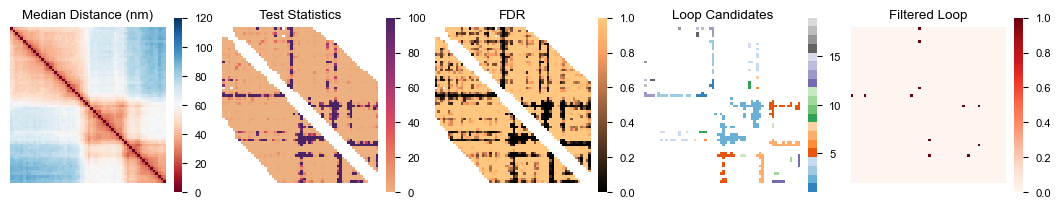

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(10.5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(oadata, inplace=False), ax=axes[0], vmax=120, title="Median Distance (nm)")
sf.pl.pairwise_heatmap(loop_res["stat"], ax=axes[1], cmap="flare", vmin=0, vmax=1e2, title="Test Statistics")
sf.pl.pairwise_heatmap(loop_res["fdr"], ax=axes[2], cmap="copper", vmax=1, title="FDR")
sf.pl.pairwise_heatmap(loop_res["label"], ax=axes[3], cmap="tab20c", title="Loop Candidates")
sf.pl.pairwise_heatmap(loop_res["final"], ax=axes[4], cmap="Reds", title="Filtered Loop")
fig.savefig(os.path.join(out_dire, "Ex_Loop.pdf"), bbox_inches="tight")

In [9]:
adata_endo = adata[adata.obs["cell_type"] == "Endo"]
adata_astro = adata[adata.obs["cell_type"] == "Astro"]

Found 0 differential loops, while 6 are not differential loops.


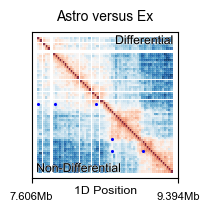

In [13]:
from utils.maps import pair_loop_map
diffloop = sf.tl.DiffLoop(adata_astro, oadata)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
fig = pair_loop_map(adata_astro, oadata, df, "chr3")
fig.suptitle("Astro versus Ex", fontsize=10)
fig.savefig(os.path.join(out_dire, "Astro_Ex_Loop.pdf"), bbox_inches="tight")

In [14]:
df[["c1", "s1", "e1", "c2", "s2", "e2", "fdr"]]

,c1,s1,e1,c2,s2,e2,fdr
0,chr3,7675000,7700000,chr3,8475000,8500000,0.915455
1,chr3,7875000,7900000,chr3,8475000,8500000,0.915455
2,chr3,8375000,8400000,chr3,8475000,8500000,0.915455
3,chr3,8575000,8600000,chr3,8900000,8925000,0.915455
4,chr3,8575000,8600000,chr3,9050000,9075000,0.915455
5,chr3,8950000,8975000,chr3,9050000,9075000,0.243232


Found 4 differential loops, while 2 are not differential loops.


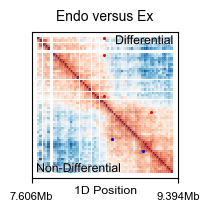

In [12]:
diffloop = sf.tl.DiffLoop(adata_endo, oadata)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
fig = pair_loop_map(adata_endo, oadata, df, "chr3")
fig.suptitle("Endo versus Ex", fontsize=10)
fig.savefig(os.path.join(out_dire, "Endo_Ex_Loop.pdf"), bbox_inches="tight")

In [16]:
df[["c1", "s1", "e1", "c2", "s2", "e2", "fdr"]]

,c1,s1,e1,c2,s2,e2,fdr
0,chr3,7675000,7700000,chr3,8475000,8500000,0.041236
1,chr3,7875000,7900000,chr3,8475000,8500000,0.000067
2,chr3,8375000,8400000,chr3,8475000,8500000,0.014833
3,chr3,8575000,8600000,chr3,8900000,8925000,0.416674
4,chr3,8575000,8600000,chr3,9050000,9075000,0.037286
5,chr3,8950000,8975000,chr3,9050000,9075000,0.416674


Found 0 differential loops, while 6 are not differential loops.


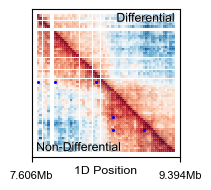

In [17]:
diffloop = sf.tl.DiffLoop(adata_astro, oadata)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
fig = pair_loop_map(adata_endo, oadata, df, "chr3")
fig.savefig(os.path.join(out_dire, "Endo_Astro_Loop.pdf"), bbox_inches="tight")

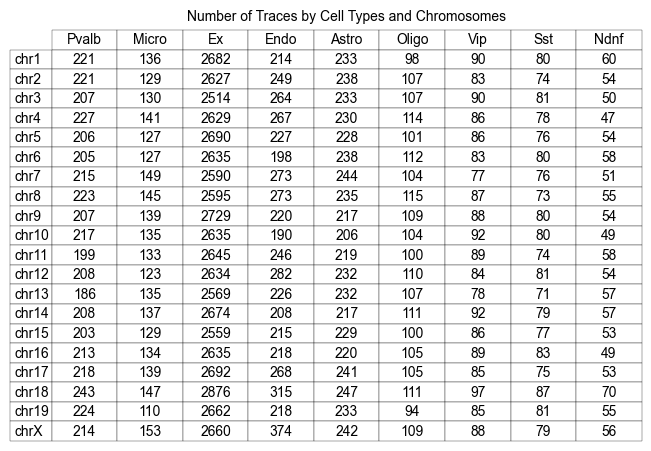

In [14]:
rows = []
for chr_id in loader.chr_ids:
    adata = loader.create_adata(chr_id)
    sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
    adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)
    d = Counter(adata.obs["cell_type"])
    d["Chrom"] = chr_id
    rows.append(d)
df = pd.DataFrame(rows).sort_values("Chrom").set_index("Chrom")
df = df.loc[[f"chr{i}" for i in range(1, 20)]+["chrX"]]
fig, ax = plt.subplots()
ax.axis("off")
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, 
         cellLoc="center", loc="center")
ax.set_title("Number of Traces by Cell Types and Chromosomes", 
             y=1.02, fontsize=10)
out_fname = os.path.join(out_dire, "takei_science_count.pdf")
fig.savefig(out_fname, bbox_inches="tight")

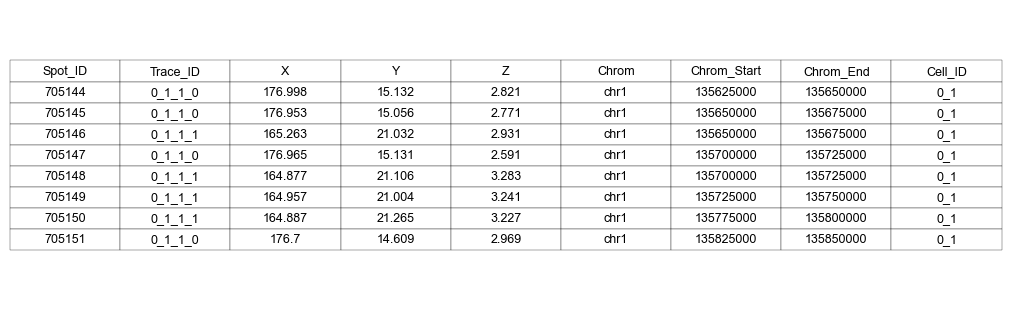

In [28]:
df = pd.read_csv(dtree["takei_nature_2021","25Kb","rep1"], skiprows=14)
cols = df.columns.values; cols[0] = "Spot_ID"; cols[-1] = "Extra_Cell_ROI_ID"
df.columns = cols; df = df.iloc[:8,:-1]
fig, ax = plt.subplots(figsize=(10, 3))
ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc="center")
ax.axis("off")
fig.savefig(os.path.join(out_dire, "fof_ct.pdf"), bbox_inches="tight")

## 129 and CAST allele

In [4]:
dtree["huang_ng_2021"]

{'between': '4DNFI2RCYFJU.csv',
 'between_rna': '4DNFI9KE6AII.csv',
 'downstream': '4DNFI5Y2PIJM.csv',
 'downstream_rna': '4DNFIKPGMZJ8.csv',
 'between_mutant': '4DNFIA8DHAFV.csv'}

`between` and `between_rna` are the experimental groups. 4 CTCF binding sites are inserted between the Sox2 promoter and the super enhancer in the CAST allele. This should lower the Sox2 expression from CAST allele. `between_rna` also has Sox2 RNA expression level.

`downstream` and `downstream_rna` are the control groups. The CTCF binding sites are inserted downstream of the system instead of between the enhancer and the promoter. We expect no significant difference.

In [5]:
loader_ng = sf.pp.FOF_CT_Loader(dtree["huang_ng_2021","between_mutant"])
adatab = loader_ng.create_adata("chr3")
allele = adatab.obs.index.str.replace(r"^\d+_", "", regex=True)
adatab.obs["allele"] = allele
adatab129 = adatab[adatab.obs["allele"] == "129"]
adatabcast = adatab[adatab.obs["allele"] == "CAST"]
sf.pp.axis_weight(adatab, inplace=False)

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


array([0.35155619, 0.36190932, 0.28653449])

In [6]:
adatab

AnnData object with n_obs × n_vars = 1318 × 41
    obs: 'allele'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

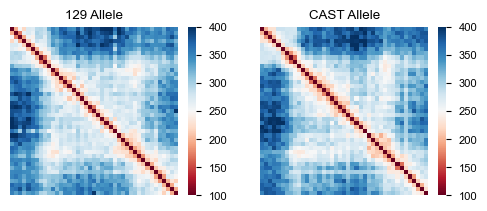

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adatab129, inplace=False), ax=axes[0],
                       title="129 Allele", vmin=100, vmax=400)
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adatabcast, inplace=False), ax=axes[1],
                       title="CAST Allele", vmin=100, vmax=400)

In [8]:
caller = sf.tl.LoopCaller()
loop_res = caller.call_loops(adatab)
loop_df = caller.to_bedpe(loop_res, adatab)
loop_df[loop_df["final"]]

,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final
344,chr3,34646078,34651078,chr3,34751078,34756078,7.096426e+11,4.485301e-13,1.036105e-10,True,1.0,True,True


In [9]:
row = loop_df[loop_df["final"]].iloc[0]
adatab.var[adatab.var["Chrom_Start"].isin([row.s1, row.s2])]

,Chrom_Start,Chrom_End
locus,,
loc9,34646078,34651078
loc30,34751078,34756078


In [10]:
df = caller.to_bedpe(caller.call_loops(adatab129), adatab129)
df[df["summit"]]

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:187: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["weight"] = {


,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final
344,chr3,34646078,34651078,chr3,34751078,34756078,7.063764e+11,4.505285e-13,1.040721e-10,True,1.0,True,True


In [11]:
df = caller.to_bedpe(caller.call_loops(adatabcast), adatabcast)
df[df["summit"]]

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:187: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["weight"] = {


,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final
344,chr3,34646078,34651078,chr3,34751078,34756078,6.705034e+11,4.747314e-13,1.096629e-10,True,1.0,True,True


In [12]:
diffloop = sf.tl.DiffLoop(adatab129, adatabcast)
res = diffloop.diff_loops(loop_df[loop_df["final"]])
df = diffloop.to_bedpe(res, 0.1)
df

Found 1 differential loops, while 0 are not differential loops.


,c1,s1,e1,c2,s2,e2,pval,fdr,log_fdr,diff
0,chr3,34646078,34651078,chr3,34751078,34756078,0.026092,0.026092,-3.646127,True
